#Sprawozdanie z laboratorium - sieci neuronowe

**Temat:** Analiza sentymentu

**Skład grupy:** 

Aleksandra Rykaczewska, Marika Jońca, Klaudia Biernat

**Opis zadania:**

- Naszym zadaniem jest przeanalizowanie otrzymanych danych, stworzenie modelu uczącego sieć oraz analiza stworzonego modelu. Sieć ta ma określać sentyment, negatywny bądź pozytywny, danego tekstu korzystając z recenzji filmów z IMDB. 



#Dane

Zestaw danych, z którego będziemy korzystać pochodzi z biblioteki `tensorflow_dataset`.  Jest to ogólno dostępna biblioteka, która umożliwia nam dostęp do różnych zbiorów danych. Do analizy sentymentu będziemy posługiwać się danymi ze zbioru `imbd_reviews` zawierającego 8000 subsłów.

Baza ta składa się z 100 000 rekordów, zawierajacych po 25000 recenzji zbioru treningowego i zbioru uczącego oraz 50000 recenzji o nieokreślonym sentymencie, które można wykorzystać do trenowania sieci bez nadzoru.








In [0]:
!pip install tfds-nightly

In [0]:
!pip install -U tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
import tensorflow as tf
import numpy as np

In [0]:
from tensorflow import keras

In [0]:
import tensorflow_datasets as tfds

Załadujemy nasze dane.

In [0]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True,
    with_info=True)

#Eksploracyjna Analiza danych



Liczba danych testowych:

In [0]:
info.splits['test'].num_examples

25000

Liczba danych treningowych: 

In [0]:
info.splits['train'].num_examples

25000

Liczba danych ze zbioru unsupervised:

In [0]:
info.splits['unsupervised'].num_examples

50000

In [0]:
#Liczba klas (0 i 1 gdzie 0 - negatywne, 1 - pozytywne)
info.features['label'].num_classes

2

Używając `SubwordTextEncoder`, który




In [0]:
encoder = info.features['text'].encoder
data = [i for i in train_data]


Dla ułatwienia stworzymy sobie funkcje, które będa mówić nam jaki sentyment ma recenzja o danym id oraz takie, które wyświetlą nam przykładowe recenzje pozytywne oraz negatywne z zadanego zbioru id.

In [0]:
def jaki_sentyment_dla_id(id):
  if ((data[id][1]).numpy()==0):
    print("Recenzja negatywna")
  else:
    print("Recenzja pozytywna")

def przykladowa_pozytywna(od_id,do_id):       
  for i in range(od_id,do_id):
    if ((data[i][1]).numpy()==1):
      print("Id recenzji: ",i)
      return encoder.decode(data[i][0].numpy())
def przykladowa_negatywna(od_id,do_id):       
  for i in range(od_id,do_id):
    if ((data[i][1]).numpy()==0):
      print("Id recenzji: ",i)
      return encoder.decode(data[i][0].numpy())
  print("Dla id od {} do {} nie ma negatywnej recenzji".format(od_id, do_id))

Wyświetlimy teraz przykładową recenzje pozytywną, a następnie negatywną.

In [0]:
przykladowa_pozytywna(0,10)

Id recenzji:  0


"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a cliché, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not really Dickens

In [0]:
przykladowa_negatywna(0,10)

Id recenzji:  6


'Just because someone is under the age of 10 does not mean they are stupid. If your child likes this film you\'d better have him/her tested. I am continually amazed at how so many people can be involved in something that turns out so bad. This "film" is a showcase for digital wizardry AND NOTHING ELSE. The writing is horrid. I can\'t remember when I\'ve heard such bad dialogue. The songs are beyond wretched. The acting is sub-par but then the actors were not given much. Who decided to employ Joey Fatone? He cannot sing and he is ugly as sin.<br /><br />The worst thing is the obviousness of it all. It is as if the writers went out of their way to make it all as stupid as possible. Great children\'s movies are wicked, smart and full of wit - films like Shrek and Toy Story in recent years, Willie Wonka and The Witches to mention two of the past. But in the continual dumbing-down of American more are flocking to dreck like Finding Nemo (yes, that\'s right), the recent Charlie & The Chocola

In [0]:
jaki_sentyment_dla_id(123)

Recenzja pozytywna


In [0]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [0]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, train_data.output_shapes))

test_batches = (
    test_data
    .padded_batch(32, train_data.output_shapes))

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


In [0]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


`Embedding` jest wartwą, która dokonuje transformacji pojedynczej liczby na rzeczywisty 16-wymiarowy wektor. Jest to w istocie redukcja wymiaru z `encoder.vocab_size` (czyli 8000) do 16.

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 13s 17ms/step - loss: 0.6809 - accuracy: 0.6403 - val_loss: 0.6629 - val_accuracy: 0.6917
Epoch 2/10
782/782 [==============================] - 9s 12ms/step - loss: 0.6204 - accuracy: 0.7572 - val_loss: 0.5976 - val_accuracy: 0.7271
Epoch 3/10
782/782 [==============================] - 9s 12ms/step - loss: 0.5412 - accuracy: 0.8060 - val_loss: 0.5319 - val_accuracy: 0.8021
Epoch 4/10
782/782 [==============================] - 9s 12ms/step - loss: 0.4751 - accuracy: 0.8386 - val_loss: 0.4779 - val_accuracy: 0.8375
Epoch 5/10
782/782 [==============================] - 10s 12ms/step - loss: 0.4239 - accuracy: 0.8635 - val_loss: 0.4340 - val_accuracy: 0.8500
Epoch 6/10
782/782 [==============================] - 10s 12ms/step - loss: 0.3826 - accuracy: 0.8773 - val_loss: 0.4024 - val_accuracy: 0.8646
Epoch 7/10
782/782 [==============================] - 10s 12ms/step - loss: 0.3500 - accuracy: 0.8861 - val_loss: 0.3761 - val_accuracy: 0.

In [0]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

    782/Unknown - 8s 10ms/step - loss: 0.3336 - accuracy: 0.8734Loss:  0.3335993419903928
Accuracy:  0.8734


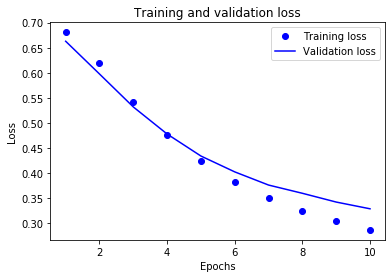

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

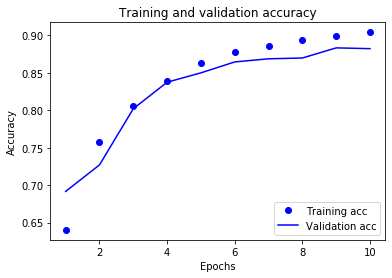

In [0]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

############################################################################


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [0]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [38]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/2
391/391 [==============================] - 932s 2s/step - loss: 0.6790 - accuracy: 0.5722 - val_loss: 0.5380 - val_accuracy: 0.7385
Epoch 2/2
391/391 [==============================] - 918s 2s/step - loss: 0.4379 - accuracy: 0.8107 - val_loss: 0.3497 - val_accuracy: 0.8578


In [39]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 204s 522ms/step - loss: 0.3544 - accuracy: 0.8533Test Loss: 0.3543778675443986
Test Accuracy: 0.8532800078392029


In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sentence, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

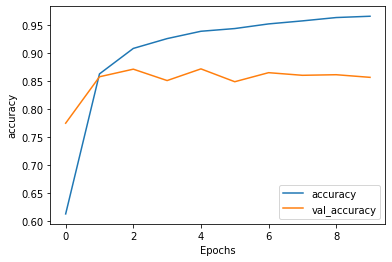

In [0]:
plot_graphs(history, 'accuracy')

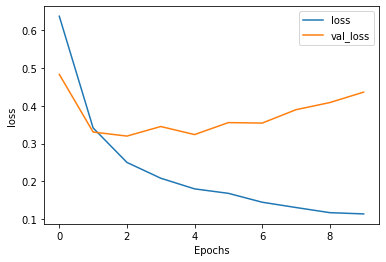

In [0]:
plot_graphs(history, 'loss')

###########################################################

In [44]:
#import potrzebnych pakietów
import torch
from torch import nn, optim
from torchtext import data, datasets
import numpy as np
import random

!pip install progressbar2

from datetime import datetime


In [0]:

torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
random.seed(12)



In [0]:
USE_GPU=0
#Sprawdzanie czy CUDA jest włączone, a sprawdzamy to po to żeby wiedziec czy bedziemy korzystali z mocy obliczeniowej co pomoże nam szybciej przetrenować sieć
device = torch.device('cuda' if (torch.cuda.is_available() and USE_GPU) else 'cpu')

In [0]:
#funkcja dzieląca nasz tekst na słowa
def tokenize(text):
    return text.lower().split()

In [0]:
# funckja dokładności, pomoże nam policzyć dokładność klasyfikacji
def accuracy(preds, y):
    
    preds = torch.nn.functional.softmax(preds, dim=1)
    # maksymalne wartosci we wierszu
    _, indices = preds.max(dim=1)
    
    correct = (indices == y).float()  
    acc = correct.sum()/len(correct)
    return acc

In [49]:
#wczytywanie danych
#definiujemy text odpowiednie za przetworzenie tekstu i etykiety - neg i pos
TEXT = data.Field(lower=True,
                  include_lengths=True,
                  tokenize=tokenize)
LABEL = data.LabelField()

#wczytujemy
train_ds, valid_ds = datasets.IMDB.splits(TEXT, LABEL)

#długości danych
print(f'train={len(train_ds)} valid={len(valid_ds)}')

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:10<00:00, 8.16MB/s]


train=25000 valid=25000


In [50]:
# budowa słownika - ważne! bo zdanie przedstawiamy jako ciąg liczb, budujemy dwa słowniki
TEXT.build_vocab(train_ds,
                 min_freq=10,
                 max_size=10000 ) 
LABEL.build_vocab(train_ds)

print(TEXT.vocab.freqs.most_common(10)) #najpopularniejsze wyrazy
print(TEXT.vocab.freqs.most_common()[:-11:-1])
vocab = TEXT.vocab

vocab_size = len(vocab) # wiekszy rozmiar niz zadalismy bo dodają sie dwa pola automatycznie
print(f'vocab_size={vocab_size}')
print(list(vocab.stoi.keys())[0:10])

print(LABEL.vocab.stoi.keys())

[('the', 322198), ('a', 159953), ('and', 158572), ('of', 144462), ('to', 133967), ('is', 104171), ('in', 90527), ('i', 70480), ('this', 69714), ('that', 66292)]
[('crappily', 1), ('hugging/kissing', 1), ('pictures/posters', 1), ('jackhammered', 1), ('results...', 1), ('s--t!!', 1), ('cynthia)', 1), ("'loveable'", 1), ('threatening?', 1), ('encounter?', 1)]
vocab_size=10002
['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'i']
dict_keys(['neg', 'pos'])


In [0]:
#parametry
n_hid=256
n_embed=100
n_layers=1
batch_size = 8

input_dim = vocab_size # 10002 , bo 2 wiecej niz zadalismy
output_dim = len(LABEL.vocab) # 2, bo neg i pos

In [0]:

print(f'Parametry modelu')
print(f'input_dim={input_dim}, output={output_dim}')
print(f'n_layers={n_layers}, n_hid={n_hid} embed={n_embed}')
print(f'batch={batch_size}')

Parametry modelu
input_dim=10002, output=2
n_layers=1, n_hid=256 embed=100
batch=8


In [0]:
#tworzenie iteratorów, grupujemy teksty o podobnej długości i pobieramy je w paczkach o rozmiarze batch_size
train_iter = data.BucketIterator(
    train_ds,
    batch_size=batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True, device=device)

In [0]:
valid_iter = data.BucketIterator(
    valid_ds, batch_size=batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True, device=device)

In [0]:
#budowa modułu
class SeqRNN(nn.Module):

    def __init__(self, input_dim,
                 output_dim, embed_size,
                 hidden_size, num_layers=1,
                 dropout=0.1,vectors=None ):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.embed = nn.Embedding(input_dim, embed_size) #kodujemy poszczególne słowa na wektory
        if vectors:
            self.embed.weight.data.copy_(vectors)

        
        self.drop = nn.Dropout(dropout)

        self.rnn = nn.LSTM(embed_size, hidden_size,
                            num_layers, batch_first=False)
        
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, seq):
        
        len_seq, bs = seq.shape
        w_embed = self.embed(seq)
        w_embed = self.drop(w_embed)
    
        output, _ = self.rnn(w_embed)
        
        
        last_output = output[-1, :, :]
        
        last_output = self.drop(last_output)

        out = self.linear(last_output)
        return out

In [55]:
model = SeqRNN(input_dim=input_dim,
               output_dim=output_dim,
               embed_size=n_embed, hidden_size=n_hid)
model.to(device)

SeqRNN(
  (embed): Embedding(10002, 100)
  (drop): Dropout(p=0.1, inplace=False)
  (rnn): LSTM(100, 256)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)

In [0]:
#funckja straty
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

epoch_loss = 0
epoch_acc = 0
epoch = 1

In [57]:
for e in range(epoch):

    start_time = datetime.now()
    model.train()
    
    for batch_idx, batch in enumerate(train_iter):
        model.zero_grad()
        
        batch_text = batch.text[0].to(device) 
        batch_label = batch.label.to(device)
        
        predictions = model(batch_text)
        
        loss = criterion(predictions, batch_label)
        epoch_loss += loss.item()

        # wsteczna propagacja
        loss.backward()
        optimizer.step()

       

   
    epoch_loss = epoch_loss / len(train_iter)

    time_elapsed = datetime.now() - start_time

   
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_iter):
            
            batch_text = batch.text[0] 
            batch_label = batch.label
            # dane wyjściowe modelu
            predictions = model(batch_text)
            # obliczamy dokładność
            acc = accuracy(predictions, batch_label)

            epoch_acc += acc
            

    epoch_acc = epoch_acc/len(valid_iter)
   

    # podsumowanie
    print(
        f'Epoch {e}/{epoch} loss={epoch_loss} acc={epoch_acc} time={time_elapsed}')
    epoch_loss = 0
    epoch_acc = 0

Epoch 0/1 loss=0.6498711192369461 acc=0.7609599828720093 time=0:35:03.906210
